In [611]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [612]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.spatial.transform import Rotation
import cv2
import pandas as pd
from scipy.spatial.distance import cdist
import plotly.graph_objects as go


In [613]:
K = [ 909.95300569, 0., 635.79822139, 0., 909.95300569, 385.66617804, 0., 0., 1. ]
EE2CAM_ROT = Rotation.from_euler("xyz", [0, 90, 0], degrees=True).as_matrix()
K = np.array(K).reshape(3, 3)

In [614]:
MOCK_DATA = False
MOCK_DATA_NOISY = True
FILTER_BASELINE = True
FILTER_CONFIDENCE = True
FILTER_SCREW_NUMBER = True
RESULT_FROM_DEPTH_MEASUREMENTS = True

In [615]:
num_screws = 5

if MOCK_DATA:
    # Generate mock data
    screw_center = np.array([1, 0, 0])
    screw_circle_radius = 0.05
    screw_positions = []
    for i in range(num_screws):
        ang = i * 2*np.pi / num_screws
        screw_positions.append(screw_center + np.array([screw_circle_radius*np.cos(ang), screw_circle_radius*np.sin(ang), 0]))
    mock_screw_positions = np.stack(screw_positions)

    # Mock poses
    num_pictures = 15
    cam_base_pos = [1, 0, 0.5]
    cam_rot = Rotation.from_euler("xyz",[180, 0, 0],degrees=True).as_matrix()
    poses = np.stack([np.eye(4) for i in range(num_pictures)])
    for i in range(num_pictures):
        rand_ang = np.random.random()*2*np.pi
        rand_rotm = np.array([[np.cos(rand_ang), np.sin(rand_ang)],[-np.sin(rand_ang), np.cos(rand_ang)]])
        cam_pos_deviation = np.dot(rand_rotm,np.array([0,1]))
        cam_pos_deviation = 0.1*np.array([*cam_pos_deviation, 0])
        poses[i][:3,3] = cam_base_pos
        poses[i][:3,3] += cam_pos_deviation
        poses[i][:3,:3] = cam_rot
    # Pose given as cam2world

    # Mock detections
    detections = np.zeros((num_pictures, num_screws, 2))
    for i in range(num_pictures):
        cam_pose = poses[i]
        screw_positions_img = np.zeros((num_screws,2))
        for j in range(num_screws):
            screw_position_world_hom = np.hstack([mock_screw_positions[j],1])
            screw_position_cam_hom = np.dot(np.linalg.inv(cam_pose), screw_position_world_hom)
            screw_position_cam = screw_position_cam_hom[:3] / screw_position_cam_hom[-1]
            screw_position_img_hom = np.dot(K, screw_position_cam)
            screw_positions_img[j,:] = screw_position_img_hom[:2] / screw_position_img_hom[-1]
            
            if MOCK_DATA_NOISY:
                # Add some noise
                screw_positions_img[j,:] += np.random.normal(scale=5, size=2)
        img = np.zeros((720, 1280, 3), dtype=np.uint8)
        for (u, v) in screw_positions_img:
            u_i, v_i = int(round(u)), int(round(v))
            if 0 <= u_i < img.shape[1] and 0 <= v_i < img.shape[0]:
                cv2.circle(img, (u_i, v_i), radius=6, color=(0, 0, 255), thickness=2)
        plt.figure(figsize=(5, 5))
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.axis("off")
        plt.title("Mock screw positions (image)")
        plt.show()

        detections[i, :] = screw_positions_img

    poses = np.repeat(poses,num_screws,axis=0)
    poses = [poses[i] for i in range(poses.shape[0])]
    img = np.repeat(list(range(num_pictures)),num_screws,axis=0)
    x = detections[:,:,0].flatten()
    y = detections[:,:,1].flatten()
    data = {
        "img": img,
        "pose": poses,
        "x": x,
        "y": y
    }

In [616]:
if not MOCK_DATA:
    # Open collected data
    with open("data/20260213_171657/_screw_detections.csv", "r") as f:
        data = f.read().splitlines()
        headers = data[0].split(",")
        data = data[1:]  # Remove header
        data_dict = {header: [] for header in headers}
        for row in data:
            values = row.split(",")
            for header, value in zip(headers, values):
                data_dict[header].append(value)
    # Make pose into TF matrices
    poses = data_dict["pose"]
    for i in range(len(poses)):
        pose = poses[i]
        pose = [float(x.split(">")[1]) for x in pose.split(";")]
        pos =  pose[:3]
        quat = pose[3:]
        matrix = np.eye(4)
        matrix[:3, 3] = pos
        rotm = Rotation.from_quat(quat).as_matrix()
        matrix[:3, :3] = EE2CAM_ROT @ rotm  # Apply the fixed rotation from EE to CAM
        data_dict["pose"][i] = matrix
    data = data_dict
    timestamps = np.unique(data["timestamp"])
    timestamp_ids = {timestamp: i for i, timestamp in enumerate(timestamps)}
    data["img"] = [timestamp_ids[t] for t in data["timestamp"]]
    num_pictures = len(timestamps)
    data["img_filename"] = [f"img_{timestamp}.jpg" for timestamp in data["timestamp"]]

In [617]:
data["ray_origin"] = []
data["ray_direction"] = []
data["ray_num"] = []

ray_idx = 0
last_img_idx = 0
for img_idx, u, v, pose in zip(data["img"], data["x"], data["y"], data["pose"]):
    u = float(u)
    v = float(v)
    pixel_homogeneous = np.array([u, v, 1.0])

    ray_direction_cam = np.linalg.inv(K) @ pixel_homogeneous
    ray_direction_cam /= np.linalg.norm(ray_direction_cam)

    rotation = Rotation.from_matrix(pose[:3, :3])
    ray_direction_world = rotation.apply(ray_direction_cam)
    ray_origin = pose[:3, 3]

    data["ray_origin"].append(ray_origin)
    data["ray_direction"].append(ray_direction_world)

    if img_idx == last_img_idx:
        data["ray_num"].append(ray_idx)
        ray_idx += 1
    else:
        ray_idx = 0
        data["ray_num"].append(ray_idx)
        ray_idx += 1
        
    last_img_idx = img_idx

In [618]:
data = pd.DataFrame.from_dict(data)
data

timestamp class        x        y width height confidence depth  \
0   20260213_171730     0  656.539  352.796    23     24       0.84     0   
1   20260213_171730     0  519.594  535.706    24     26       0.83   410   
2   20260213_171730     0  474.069  327.928    23     22       0.81     0   
3   20260213_171730     0  360.377  544.787    26     27       0.78   402   
4   20260213_171730     0  323.189   401.37    25     26       0.74   413   
..              ...   ...      ...      ...   ...    ...        ...   ...   
67  20260213_172335     0  652.891  267.919    30     30       0.86     0   
68  20260213_172335     0  764.992  528.839    30     31       0.82   310   
69  20260213_172335     0   902.59  260.228    30     31       0.81   324   
70  20260213_172335     0  487.137  394.399    32     36       0.67     0   
71  20260213_172335     0  565.601  565.948    30     33       0.31     0   

                                                 pose  img  \
0   [[0.08218302165946899, 0.9837388148945195, -0....    0   
1   [[0.08218302165946899, 0.9837388148945195, -0....    0   
2   [[0.08218302165946899, 0.9837388148945195, -0....    0   
3   [[0.08218302165946899, 0.9837388148945195, -0....    0   
4   [[0.08218302165946899, 0.9837388148945195, -0....    0   
..                                                ...  ...   
67  [[-0.04994989700912998, 0.9751692957112422, -0...   14   
68  [[-0.04994989700912998, 0.9751692957112422, -0...   14   
69  [[-0.04994989700912998, 0.9751692957112422, -0...   14   
70  [[-0.04994989700912998, 0.9751692957112422, -0...   14   
71  [[-0.04994989700912998, 0.9751692957112422, -0...   14   

               img_filename                ray_origin  \
0   img_20260213_171730.jpg  [0.6176, 0.2336, 0.5795]   
1   img_20260213_171730.jpg  [0.6176, 0.2336, 0.5795]   
2   img_20260213_171730.jpg  [0.6176, 0.2336, 0.5795]   
3   img_20260213_171730.jpg  [0.6176, 0.2336, 0.5795]   
4   img_20260213_171730.jpg  [0.6176, 0.2336, 0.5795]   
..                      ...                       ...   
67  img_20260213_172335.jpg  [0.6252, 0.1889, 0.4543]   
68  img_20260213_172335.jpg  [0.6252, 0.1889, 0.4543]   
69  img_20260213_172335.jpg  [0.6252, 0.1889, 0.4543]   
70  img_20260213_172335.jpg  [0.6252, 0.1889, 0.4543]   
71  img_20260213_172335.jpg  [0.6252, 0.1889, 0.4543]   

                                        ray_direction  ray_num  
0   [-0.19318556705733153, -0.13359847541784725, -...        0  
1   [-0.007820017483971535, -0.2967013331123248, -...        1  
2   [-0.23261991512223334, -0.32184607955332045, -...        2  
3   [-0.011847723699905478, -0.44919280865197936, ...        3  
4   [-0.16165919975462334, -0.47180105009683604, -...        4  
..                                                ...      ...  
67  [-0.33998449262679237, -0.2960712137190636, -0...        0  
68  [-0.06790378041932056, -0.18412442224084244, -...        1  
69  [-0.3470669122176053, -0.03655553028718793, -0...        2  
70  [-0.19563254125453464, -0.4680156385281407, -0...        3  
71  [-0.01828940797166475, -0.3880412557892719, -0...        4  

[72 rows x 14 columns]

Camera pose for image 0:
[[ 0.08218302  0.98373881 -0.15969939  0.6176    ]
 [ 0.9812     -0.10794264 -0.15998422  0.2336    ]
 [-0.17462106 -0.14354905 -0.97411558  0.5795    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 0: [433.94232624 374.98458757]


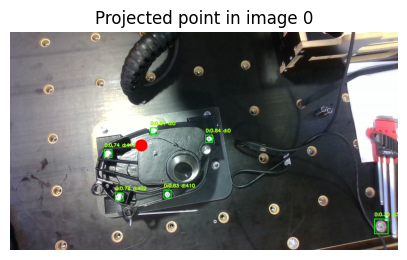

Camera pose for image 1:
[[ 0.08218302  0.98373881 -0.15969939  0.6176    ]
 [ 0.9812     -0.10794264 -0.15998422  0.2336    ]
 [-0.17462106 -0.14354905 -0.97411558  0.5795    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 1: [433.94232624 374.98458757]


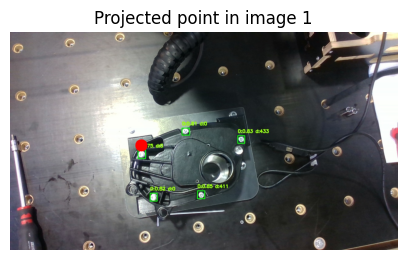

Camera pose for image 2:
[[ 0.08228596  0.98374298 -0.1596207   0.6087    ]
 [ 0.98117179 -0.1080464  -0.16008716  0.1838    ]
 [-0.17473107 -0.1434424  -0.97411156  0.5753    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 2: [502.77629707 378.84503085]


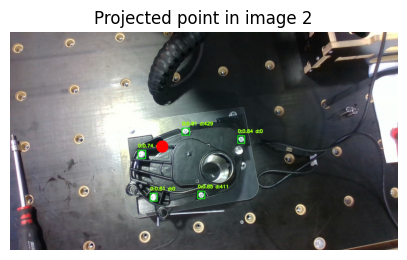

Camera pose for image 3:
[[ 0.08228596  0.98374298 -0.1596207   0.6087    ]
 [ 0.98117179 -0.1080464  -0.16008716  0.1838    ]
 [-0.17473107 -0.1434424  -0.97411156  0.5753    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 3: [502.77629707 378.84503085]


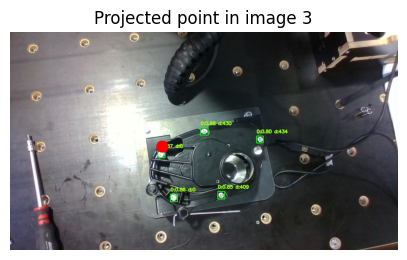

Camera pose for image 4:
[[ 0.0820383   0.98376281 -0.15962597  0.6036    ]
 [ 0.98109032 -0.1078893  -0.16069124  0.1545    ]
 [-0.175304   -0.14342466 -0.97401123  0.5729    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 4: [545.2455338  380.98878497]


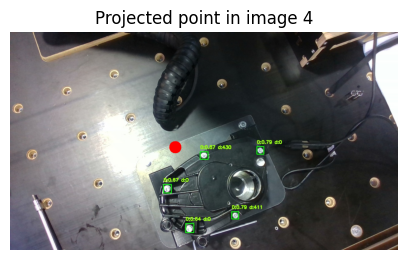

Camera pose for image 5:
[[ 0.04373882  0.98373694 -0.17420835  0.6035    ]
 [ 0.91960605 -0.10778537 -0.37776583  0.1545    ]
 [-0.39039931 -0.14368002 -0.90936485  0.5728    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 5: [753.12968934 381.30285881]


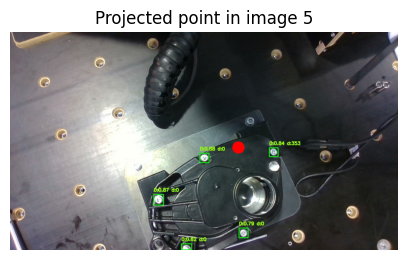

Camera pose for image 6:
[[ 0.04337105  0.98380056 -0.1739408   0.592     ]
 [ 0.91955892 -0.10737094 -0.3779985   0.1629    ]
 [-0.39055133 -0.14355463 -0.90931938  0.494     ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 6: [703.41834969 382.03360487]


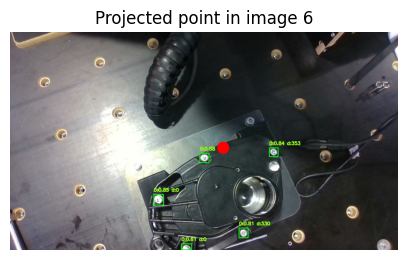

Camera pose for image 7:
[[ 0.04337105  0.98380056 -0.1739408   0.592     ]
 [ 0.91955892 -0.10737094 -0.3779985   0.1629    ]
 [-0.39055133 -0.14355463 -0.90931938  0.494     ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 7: [703.41834969 382.03360487]


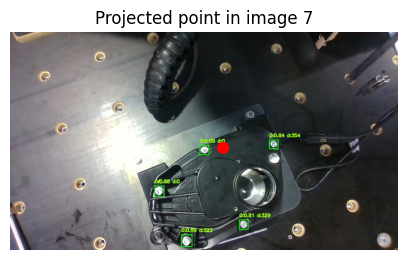

Camera pose for image 8:
[[ 0.04363479  0.98376015 -0.17410335  0.6012    ]
 [ 0.91949167 -0.10769405 -0.37807019  0.1589    ]
 [-0.39068028 -0.14358957 -0.90925846  0.4923    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 8: [708.21863404 365.30475497]


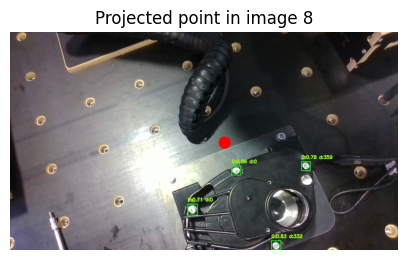

Camera pose for image 9:
[[-0.06159115  0.97508966 -0.21308843  0.5747    ]
 [ 0.92847025 -0.02237051 -0.37073246  0.09199   ]
 [-0.36626429 -0.22068011 -0.90396392  0.4965    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 9: [820.11132565 456.41788659]


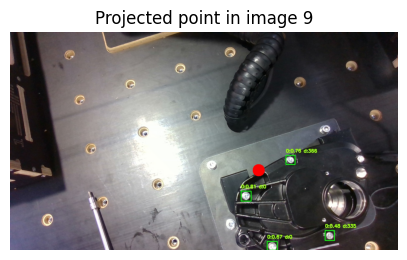

Camera pose for image 10:
[[-0.04949637  0.97508206 -0.21625235  0.5747    ]
 [ 0.947799   -0.02243154 -0.31807841  0.09199   ]
 [-0.31500343 -0.22070749 -0.92307153  0.4965    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 10: [767.50527055 455.76822673]


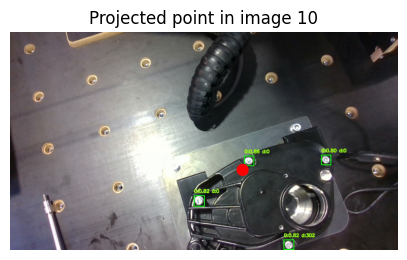

Camera pose for image 11:
[[-0.04950873  0.97508775 -0.21622386  0.5863    ]
 [ 0.94774635 -0.02244731 -0.31823415  0.1492    ]
 [-0.31515986 -0.22068074 -0.92302452  0.4619    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 11: [651.39478752 424.71030225]


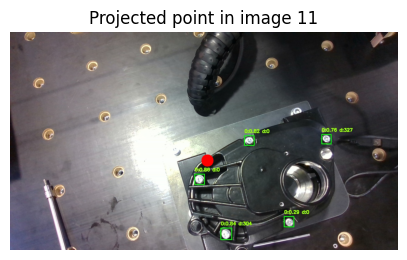

Camera pose for image 12:
[[-0.04975445  0.97508173 -0.21619461  0.6091    ]
 [ 0.94760749 -0.02230007 -0.31865773  0.1411    ]
 [-0.31553849 -0.22072227 -0.92288523  0.4566    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 12: [665.13517749 381.11010659]


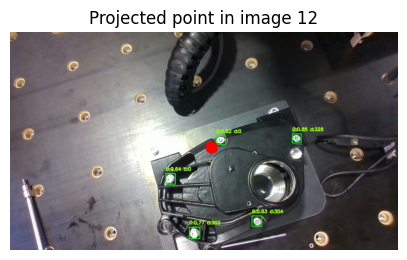

Camera pose for image 13:
[[-0.0500368   0.97514228 -0.21585611  0.62      ]
 [ 0.94750194 -0.02199327 -0.31899275  0.1739    ]
 [-0.31581069 -0.22048546 -0.92284872  0.455     ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 13: [608.43763299 362.30057904]


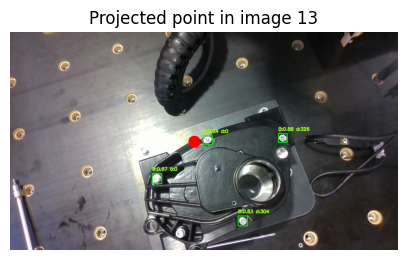

Camera pose for image 14:
[[-0.0499499   0.9751693  -0.21575415  0.6252    ]
 [ 0.94741329 -0.02210481 -0.31924824  0.1889    ]
 [-0.31609028 -0.22035476 -0.92278422  0.4543    ]
 [ 0.          0.          0.          1.        ]]
Projected point in image 14: [583.49960368 353.67491378]


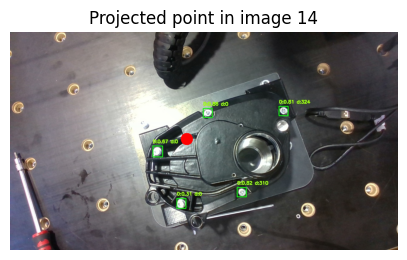

In [619]:
# Use poses and intrinsic matrix to project points into images
for img_idx in data["img"].unique():
    img_filename = data[data["img"]==img_idx]["img_filename"].iloc[0]
    img = cv2.imread(f"data/20260213_171657/{img_filename}")
    world_point = np.array([0.5, 0, 0, 1])  # Example world point in homogeneous coordinates
    cam_pose = data[data["img"]==img_idx]["pose"].iloc[0]
    print(f"Camera pose for image {img_idx}:\n{cam_pose}")
    point_cam_hom = np.linalg.inv(cam_pose) @ world_point # pose given as cam2world
    point_cam = point_cam_hom[:3] / point_cam_hom[-1]
    point_img_hom = K @ point_cam
    point_img = point_img_hom[:2] / point_img_hom[-1]
    print(f"Projected point in image {img_idx}: {point_img}")
    # Visualize the point in the image
    img_vis = img.copy()
    cv2.circle(img_vis, (int(point_img[0]), int(point_img[1])), radius=20, color=(0, 0, 255), thickness=-1)
    plt.figure(figsize=(5, 5))
    plt.imshow(cv2.cvtColor(img_vis, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.title(f"Projected point in image {img_idx}")
    plt.show()

In [620]:
data.pose.loc[0]

array([[ 0.08218302,  0.98373881, -0.15969939,  0.6176    ],
       [ 0.9812    , -0.10794264, -0.15998422,  0.2336    ],
       [-0.17462106, -0.14354905, -0.97411558,  0.5795    ],
       [ 0.        ,  0.        ,  0.        ,  1.        ]])

In [621]:
if FILTER_CONFIDENCE:
    # Keep only those detections whose confidence is higher than 0.75
    data["confidence"] = data["confidence"].astype(float)
    data = data[data["confidence"] >= 0.5].copy()  # Add .copy() here

if FILTER_SCREW_NUMBER:
    # Count number of screws per picture and filter
    data.loc[:, "num_screws"] = 0  # Initialize with .loc
    for img_id in range(num_pictures):
        mask = data["img"] == img_id
        data.loc[mask, "num_screws"] = np.sum(mask)

    data = data[data["num_screws"] == num_screws]

In [622]:
def plot_poses(poses, scale=0.05, axis_labels=True, pose_labels=None, ax=None, figsize=(8, 6)):
    """
    Visualize 4x4 pose matrices as coordinate frames using Plotly.
    - poses: single 4x4 array or iterable/array of shape (N,4,4)
    - scale: length of drawn axes
    - axis_labels: annotate axes ('x','y','z') for each pose
    - ax: ignored (kept for compatibility)
    Returns the plotly Figure.
    """
    poses = np.asarray(poses)
    if poses.ndim == 2 and poses.shape == (4, 4):
        poses = poses[None, ...]
    assert poses.ndim == 3 and poses.shape[1:] == (4, 4), "poses must be (N,4,4) or (4,4)"

    fig = go.Figure()
    all_points = []

    pose_labels = pose_labels if pose_labels is not None else list(range(len(poses)))

    for i, pose in zip(pose_labels, poses):
        t = pose[:3, 3]
        R = pose[:3, :3]
        for vec, color, lbl in zip(R.T, ("red", "green", "blue"), ("x", "y", "z")):
            end = t + vec * scale
            line = np.vstack([t, end])
            fig.add_trace(go.Scatter3d(
                x=line[:, 0], y=line[:, 1], z=line[:, 2],
                mode="lines", line=dict(color=color, width=4), showlegend=False
            ))
            fig.add_trace(go.Scatter3d(
                x=[t[0]], y=[t[1]], z=[t[2]],
                mode="markers", marker=dict(color=color, size=4), showlegend=False
            ))
            if axis_labels:
                fig.add_trace(go.Scatter3d(
                    x=[end[0]], y=[end[1]], z=[end[2]],
                    mode="text", text=[f"{lbl}{i}"], textposition="top center",
                    showlegend=False
                ))
        all_points.extend([t, t + R[:, 0] * scale, t + R[:, 1] * scale, t + R[:, 2] * scale])

    all_points = np.vstack(all_points)
    mins = all_points.min(axis=0)
    maxs = all_points.max(axis=0)
    centers = 0.5 * (mins + maxs)
    radius = (maxs - mins).max() / 2.0

    fig.update_layout(
        scene=dict(
            xaxis=dict(title="X", range=[centers[0] - radius, centers[0] + radius]),
            yaxis=dict(title="Y", range=[centers[1] - radius, centers[1] + radius]),
            zaxis=dict(title="Z", range=[centers[2] - radius, centers[2] + radius]),
        ),
        width=figsize[0] * 100,
        height=figsize[1] * 100,
    )
    # fig.show()
    return fig

# Only keep one pose per image
unique_img_df = data.groupby("img").first()
poses = unique_img_df["pose"].values
img_idxes = unique_img_df.index.values

plot_poses(np.stack(poses), pose_labels=img_idxes)

In [623]:

if FILTER_BASELINE:
    # 1. Extract unique camera positions
    img_indices = data["img"].unique()
    camera_positions = []
    for img in img_indices:
        pos = data[data["img"] == img]["pose"].iloc[0][:3, 3]
        camera_positions.append(pos)
    camera_positions = np.array(camera_positions)

    # --- CONFIGURATION ---
    N_TO_KEEP = num_pictures // 3  # Keep one-third of the total pictures
    N_TOTAL = len(img_indices)

    if N_TOTAL <= N_TO_KEEP:
        selected_indices = list(range(N_TOTAL))
        print(f"Keeping all {N_TOTAL} images as they are fewer than N_TO_KEEP.")
    else:
        # --- Farthest Point Sampling (FPS) ---
        
        # Start with the two cameras that are furthest apart globally
        dist_matrix = cdist(camera_positions, camera_positions, metric='euclidean')
        i, j = np.unravel_index(np.argmax(dist_matrix), dist_matrix.shape)
        
        selected_indices = [i, j]
        remaining_indices = list(set(range(N_TOTAL)) - set(selected_indices))
        
        while len(selected_indices) < N_TO_KEEP:
            # Get coordinates of points we have and points we don't
            pts_selected = camera_positions[selected_indices]
            pts_remaining = camera_positions[remaining_indices]
            
            # Calculate distance from every 'remaining' point to every 'selected' point
            # Result shape: (len(remaining), len(selected))
            dists_to_selected = cdist(pts_remaining, pts_selected, metric='euclidean')
            
            # For each remaining point, find the distance to its NEAREST selected neighbor
            # (We want to pick the point that is 'most alone' or furthest from the current set)
            min_dists = np.min(dists_to_selected, axis=1)
            
            # The next point to add is the one that has the largest 'minimum distance'
            best_idx_in_remaining = np.argmax(min_dists)
            best_global_idx = remaining_indices[best_idx_in_remaining]
            
            selected_indices.append(best_global_idx)
            remaining_indices.pop(best_idx_in_remaining)

    # 2. Filter the Dataframe
    keep_img_ids = img_indices[selected_indices]
    to_remove = [img for img in img_indices if img not in keep_img_ids]

    data = data[data["img"].isin(keep_img_ids)].copy()
    img_indices = data["img"].unique()

    print(f"Successfully selected {len(keep_img_ids)} images with optimized spatial baseline.")
    print("Removed due to redundancy:", to_remove)

Successfully selected 5 images with optimized spatial baseline.
Removed due to redundancy: [1, 3, 4, 7]


In [624]:
# Plot filtered poses
unique_img_df = data.groupby("img").first()
poses = unique_img_df["pose"].values
img_idxes = unique_img_df.index.values

plot_poses(np.stack(poses), pose_labels=img_idxes)

In [625]:
def closest_point_between_rays(
    ray1_origin, ray1_direction, ray2_origin, ray2_direction, point_in_front=False, point_on_ray1=False
):
    # Compute the cross product of the direction vectors
    cross = np.cross(ray1_direction, ray2_direction)
    denom = np.linalg.norm(cross) ** 2

    # If the rays are parallel (cross product is zero), return None
    if denom < 1e-6:
        return None, None

    # Compute the parameters for the closest points on each ray
    t1 = np.linalg.det([ray2_origin - ray1_origin, ray2_direction, cross]) / denom
    t2 = np.linalg.det([ray2_origin - ray1_origin, ray1_direction, cross]) / denom

    # If point_in_front is True, ensure t1 and t2 are >= 0 (i.e., only consider points in the positive direction)
    if point_in_front:
        t1 = max(t1, 0)
        t2 = max(t2, 0)

    # Compute the closest points on each ray
    closest_point_ray1 = ray1_origin + t1 * ray1_direction
    closest_point_ray2 = ray2_origin + t2 * ray2_direction

    # Get the distance between the closest points
    distance = np.linalg.norm(closest_point_ray1 - closest_point_ray2)

    # Return the midpoint between the two closest points as the best estimate
    closest_point = (closest_point_ray1 + closest_point_ray2) / 2
    if point_on_ray1:
        closest_point = closest_point_ray1
    return closest_point, distance

def distance_of_point_from_ray(point_3D, ray_origin, ray_direction):
    ray_to_point = point_3D - ray_origin
    ray_vector = np.dot(ray_to_point, ray_direction) * ray_direction
    perpendicular_vector = ray_to_point - ray_vector

    distance = np.linalg.norm(perpendicular_vector)
    return distance

In [626]:
def reprojection_error(point3D_hyp, point2D_meas, pose):
    point3D_hyp_hom = np.hstack((point3D_hyp, 1))
    point3D_hyp_hom = np.dot(pose, point3D_hyp_hom)
    point3D_hyp = point3D_hyp[:3] / point3D_hyp[-1]
    point2D_hyp = np.dot(K, point3D_hyp)
    point2D_hyp = point2D_hyp[:2] / point2D_hyp[-1]
    error = np.linalg.norm(point2D_hyp, point2D_meas)
    return error

Ray pairing between maximum distance images

In [627]:

# Visualize the rays and the closest point

def plot_rays(ray_origins, ray_directions, colors="red", name="ray", ray_length=1.0):
    if isinstance(colors, str):
        colors = [colors for i in range(ray_origins.shape[0])]
        print(colors)
    fig = go.Figure()
    for o, d, color in zip(ray_origins, ray_directions, colors):
        line = np.vstack([o, o + d * ray_length])
        fig.add_trace(go.Scatter3d(
            x=line[:, 0], y=line[:, 1], z=line[:, 2],
            mode="lines", line=dict(color=color), name=name, showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[o[0]], y=[o[1]], z=[o[2]],
            mode="markers", marker=dict(color=color, size=4), showlegend=False
        ))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()

def plot_rays_and_points(ray_origins, ray_directions, points=None, colors="red", name="ray", point_color="green", point_size=6, ray_length=1.0):
    if isinstance(colors, str):
        colors = [colors for _ in range(ray_origins.shape[0])]
    fig = go.Figure()
    for o, d, color in zip(ray_origins, ray_directions, colors):
        line = np.vstack([o, o + d * ray_length])
        fig.add_trace(go.Scatter3d(
            x=line[:, 0], y=line[:, 1], z=line[:, 2],
            mode="lines", line=dict(color=color), name=name, showlegend=False
        ))
        fig.add_trace(go.Scatter3d(
            x=[o[0]], y=[o[1]], z=[o[2]],
            mode="markers", marker=dict(color=color, size=4), showlegend=False
        ))
    if points is not None:
        points = np.asarray(points)
        fig.add_trace(go.Scatter3d(
            x=points[:, 0], y=points[:, 1], z=points[:, 2],
            mode="markers", marker=dict(color=point_color, size=point_size), name="points", showlegend=False
        ))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()

def plot_two_rays_with_closest(ray_o1, ray_d1, ray_o2, ray_d2, closest_point):
    ray1_line = np.vstack([ray_o1, ray_o1 + ray_d1])
    ray2_line = np.vstack([ray_o2, ray_o2 + ray_d2])

    fig = go.Figure()
    fig.add_trace(go.Scatter3d(x=ray1_line[:, 0], y=ray1_line[:, 1], z=ray1_line[:, 2],
                               mode="lines", line=dict(color="red"), name="ray1"))
    fig.add_trace(go.Scatter3d(x=ray2_line[:, 0], y=ray2_line[:, 1], z=ray2_line[:, 2],
                               mode="lines", line=dict(color="blue"), name="ray2"))
    fig.add_trace(go.Scatter3d(x=[ray_o1[0]], y=[ray_o1[1]], z=[ray_o1[2]],
                               mode="markers", marker=dict(color="red", size=5), name="ray1_origin"))
    fig.add_trace(go.Scatter3d(x=[ray_o2[0]], y=[ray_o2[1]], z=[ray_o2[2]],
                               mode="markers", marker=dict(color="blue", size=5), name="ray2_origin"))
    fig.add_trace(go.Scatter3d(x=[closest_point[0]], y=[closest_point[1]], z=[closest_point[2]],
                               mode="markers", marker=dict(color="green", size=6), name="closest_point"))
    fig.update_layout(scene=dict(xaxis_title="X", yaxis_title="Y", zaxis_title="Z"))
    fig.show()


In [628]:
img_data1 = data[data["img"] == np.random.choice(img_indices)]
img_data2 = data[data["img"] == np.random.choice(img_indices)]

closest_points = {}
for idx1, detection1 in img_data1.iterrows():
    ray_o1 = detection1["ray_origin"]
    ray_d1 = detection1["ray_direction"]

    for idx2, detection2 in img_data2[["ray_origin", "ray_direction"]].iterrows():
        ray_o2 = detection2["ray_origin"]
        ray_d2 = detection2["ray_direction"]

        closest_point, distance = closest_point_between_rays(
            np.array(ray_o1),
            np.array(ray_d1),
            np.array(ray_o2),
            np.array(ray_d2),
        )
        if distance is None:
            closest_points[(idx1, idx2)] = (ray_o1, 0)
        else:
            closest_points[(idx1, idx2)] = (closest_point, distance)

print(closest_points)
# plot_two_rays_with_closest(ray_o1, ray_d1, ray_o2, ray_d2, closest_point)

{(0, 0): (array([0.6176, 0.2336, 0.5795]), 0), (0, 1): (array([0.6176, 0.2336, 0.5795]), 0.0), (0, 2): (array([0.6176, 0.2336, 0.5795]), 0.0), (0, 3): (array([0.6176, 0.2336, 0.5795]), 0.0), (0, 4): (array([0.6176, 0.2336, 0.5795]), 0.0), (1, 0): (array([0.6176, 0.2336, 0.5795]), 0.0), (1, 1): (array([0.6176, 0.2336, 0.5795]), 0), (1, 2): (array([0.6176, 0.2336, 0.5795]), 0.0), (1, 3): (array([0.6176, 0.2336, 0.5795]), 0.0), (1, 4): (array([0.6176, 0.2336, 0.5795]), 0.0), (2, 0): (array([0.6176, 0.2336, 0.5795]), 0.0), (2, 1): (array([0.6176, 0.2336, 0.5795]), 0.0), (2, 2): (array([0.6176, 0.2336, 0.5795]), 0), (2, 3): (array([0.6176, 0.2336, 0.5795]), 0.0), (2, 4): (array([0.6176, 0.2336, 0.5795]), 0.0), (3, 0): (array([0.6176, 0.2336, 0.5795]), 0.0), (3, 1): (array([0.6176, 0.2336, 0.5795]), 0.0), (3, 2): (array([0.6176, 0.2336, 0.5795]), 0.0), (3, 3): (array([0.6176, 0.2336, 0.5795]), 0), (3, 4): (array([0.6176, 0.2336, 0.5795]), 0.0), (4, 0): (array([0.6176, 0.2336, 0.5795]), 0.0),

In [629]:
cmap = plt.get_cmap()
colors = cmap(data["img"]/max(data["img"]))
all_ray_origins = np.concatenate([data["ray_origin"].to_list()])
all_ray_directions = np.concatenate([data["ray_direction"].to_list()])

plot_rays(
    all_ray_origins[11:20], 
    all_ray_directions[11:20],
    colors=colors,
    ray_length=1
)


Ray pairing between random images

In [630]:
# screw_cands = []
# matched_rays = []
# assert len(img_data1["img"].unique()) == 1, "img_data1 should contain only one unique image"
# other_image_indices = data[data["img"]!=img_data1["img"].unique()[0]]["img"].unique()
# base_img_idx = img_data1["img"].unique()[0]

# for _, row in img_data1.iterrows():
#     # Get original ray, we iterate through all of them for this image
#     base_ray_num = row["ray_num"]
#     ray_o = row["ray_origin"]
#     ray_d = row["ray_direction"]

#     # Iterate through other images
#     min_dist_cands = []
#     min_dists = []
#     min_dist_ray_indices = []
#     for idx in other_image_indices:
#         img_data = data[data["img"]==idx]

#         dists = []
#         min_dist_cand = None
#         min_dist = float("inf")
#         min_dist_ray_idx = None

#         # Iterate through rays of the other image to get closest intersection
#         for sub_idx, sub_row in img_data.iterrows():
#             sub_ray_o = sub_row["ray_origin"]
#             sub_ray_d = sub_row["ray_direction"]
#             cand, dist = closest_point_between_rays(
#                 np.array(ray_o),
#                 np.array(ray_d),
#                 np.array(sub_ray_o),
#                 np.array(sub_ray_d),
#                 point_in_front=True,
#                 point_on_ray1=True,
#             )
#             dists.append(dist)

#             # Keep the candidate with the smallest distance to the ray
#             if dist < min_dist:
#                 min_dist = dist
#                 min_dist_cand = cand
#                 min_dist_ray_idx = sub_idx
#         min_dist_cands.append(min_dist_cand)
#         min_dists.append(min_dist)
#         min_dist_ray_indices.append(min_dist_ray_idx)
    
#     dist_sums = []
#     assert len(min_dist_cands) == len(other_image_indices) == len(min_dist_ray_indices)

#     # For all candidates on the original ray, compute distance from all rays of other images and sum up
#     #   there are as many candidates as other images
#     for cand, ray_idx in zip(min_dist_cands, min_dist_ray_indices):
#         dist_sum = 0
#         for idx in other_image_indices:
#             img_data = data[data["img"]==idx]
#             for sub_idx, sub_row in img_data.iterrows():
#                 dist = distance_of_point_from_ray(
#                     cand,
#                     np.array(sub_row["ray_origin"]),
#                     np.array(sub_row["ray_direction"]),
#                 )
#                 dist_sum += dist
#         dist_sums.append(dist_sum)
#     best_cand_idx = np.argmin(dist_sums)
#     best_cand = min_dist_cands[best_cand_idx]

#     # Lastly, find the rays of the other images that are the closest (matching rays)
#     matched_indices = []
#     for idx in other_image_indices:
#         img_data = data[data["img"]==idx]

#         min_dist_ray_idx = None
#         min_dist = float("inf")
#         for sub_idx, sub_row in img_data.iterrows():
#             ray_idx = sub_row["ray_num"]
#             dist = distance_of_point_from_ray(
#                 best_cand,
#                 np.array(sub_row["ray_origin"]),
#                 np.array(sub_row["ray_direction"]),
#             )
#             if dist < min_dist:
#                 min_dist = dist
#                 min_dist_ray_idx = ray_idx
#         matched_indices.append(min_dist_ray_idx)
        
#     matched_rays.append((base_ray_num, matched_indices))
#     screw_cands.append(best_cand)

# print(screw_cands)
# print(matched_rays)
# print(other_image_indices)

In [631]:
# screw_points = []
# # Run least square optimization to minimize reprojection error of the candidates
# for screw_cand, ray_groups in zip(screw_cands, matched_rays):
#     base_ray_num, matched_indices = ray_groups
#     # Get the corresponding rays for the matched indices
#     base_ray_o = img_data1[img_data1["ray_num"]==base_ray_num]["ray_origin"].values[0]
#     base_ray_d = img_data1[img_data1["ray_num"]==base_ray_num]["ray_direction"].values[0]

#     matched_rays_data = [(base_ray_o, base_ray_d)]
#     for i, ray_idx in enumerate(matched_indices):
#         other_img_idx = other_image_indices[i]
#         other_img_data = data[data["img"]==other_img_idx]
#         ray_o = other_img_data[other_img_data["ray_num"]==ray_idx]["ray_origin"].values[0]
#         ray_d = other_img_data[other_img_data["ray_num"]==ray_idx]["ray_direction"].values[0]
#         matched_rays_data.append((ray_o, ray_d))
    
#     # Now we have the rays, we can run least square optimization to minimize reprojection error of the candidates
#     def residual_func(point3D):
#         error_sum = 0
#         for ray_o, ray_d in matched_rays_data:
#             error_sum += distance_of_point_from_ray(
#                 point3D,
#                 ray_o,
#                 ray_d,
#             )
#         return error_sum
#     result = scipy.optimize.minimize(residual_func, screw_cand)
#     print(result)
#     screw_points.append(result.x)
# print(screw_points)

In [632]:
from scipy.cluster.hierarchy import linkage, fcluster
import pandas as pd

# --- USER PARAMETER ---
N_SCREWS = num_screws  # Set the known number of screws here
# ----------------------

MAX_RAY_DIST = 0.15  # Max distance between rays
CLUSTER_DIST = 0.1  # Spatial grouping distance

candidate_points = []
candidate_ray_indices = [] 
candidate_ray_distances = [] # Store ray-to-ray distance for scoring

unique_imgs = data["img"].unique()

for i in range(len(unique_imgs)):
    for j in range(i + 1, len(unique_imgs)):
        img_a, img_b = unique_imgs[i], unique_imgs[j]
        rays_a = data[data["img"] == img_a]
        rays_b = data[data["img"] == img_b]
        
        for _, row_a in rays_a.iterrows():
            for _, row_b in rays_b.iterrows():
                pt, dist = closest_point_between_rays(
                    row_a["ray_origin"], row_a["ray_direction"],
                    row_b["ray_origin"], row_b["ray_direction"],
                    point_in_front=True
                )
                
                if pt is not None and dist < MAX_RAY_DIST:
                    # Optional: Depth filter (Z > 0)
                    # Comptue the depth of the point along the ray direction for one of the rays (e.g., ray_a)
                    ray_to_pt = pt - row_a["ray_origin"]
                    depth = np.dot(ray_to_pt, row_a["ray_direction"])
                    if depth > 0:
                        candidate_points.append(pt)
                        candidate_ray_distances.append(dist)
                        candidate_ray_indices.append([
                            (row_a["img"], row_a["ray_num"]),
                            (row_b["img"], row_b["ray_num"])
                        ])

candidate_points = np.array(candidate_points)

if len(candidate_points) > 0:
    Z = linkage(candidate_points, method='single') 
    labels = fcluster(Z, t=CLUSTER_DIST, criterion='distance')
    print(f"Clustering found {len(np.unique(labels))} potential locations.")
else:
    labels = np.array([])
    print("No valid intersections found.")

cluster_stats = []

for label in np.unique(labels):
    indices = np.where(labels == label)[0]
    
    # Calculate Metrics
    contributing_rays = []
    for idx in indices:
        contributing_rays.extend(candidate_ray_indices[idx])
    
    unique_rays = set(contributing_rays)
    unique_images = set([r[0] for r in unique_rays])
    avg_ray_dist = np.mean([candidate_ray_distances[idx] for idx in indices])
    
    cluster_stats.append({
        'label': label,
        'num_images': len(unique_images),
        'num_intersections': len(indices),
        'precision': avg_ray_dist,
        'indices': indices,
        'unique_rays': unique_rays
    })

# Sort by: 1. Max Cameras, 2. Max Intersections, 3. Min Ray Distance (Precision)
cluster_stats.sort(key=lambda x: (-x['num_images'], -x['num_intersections'], x['precision']))

# Select only the top N
best_clusters = cluster_stats[:N_SCREWS]
print(f"Selected the {len(best_clusters)} best clusters based on camera agreement.")

Clustering found 3 potential locations.
Selected the 3 best clusters based on camera agreement.


In [633]:
from scipy.optimize import least_squares

final_screw_positions = []

for cluster in best_clusters:
    # 1. Gather all rays involved in this cluster with their depth measurements
    target_rays_o = []
    target_rays_d = []
    depth_measurements = []  # NEW: store depths in mm
    
    for img_idx, ray_num in cluster['unique_rays']:
        row = data[(data["img"] == img_idx) & (data["ray_num"] == ray_num)].iloc[0]
        target_rays_o.append(row["ray_origin"])
        target_rays_d.append(row["ray_direction"])
        
        # Extract depth (convert from mm to meters if needed)
        depth_mm = float(row["depth"])
        depth_m = depth_mm / 1000.0  # Convert to meters
        depth_measurements.append(depth_m)
    
    target_rays_o = np.array(target_rays_o)
    target_rays_d = np.array(target_rays_d)
    depth_measurements = np.array(depth_measurements)
    
    # 2. NEW: Compute 3D points using depth along each ray
    points_from_depth = []
    for o, d, depth in zip(target_rays_o, target_rays_d, depth_measurements):
        if depth > 0:  # Only valid positive depths
            pt_3d = o + depth * d
            points_from_depth.append(pt_3d)
    
    # 3. Initial Guess: Mean of depth-based 3D points
    if len(points_from_depth) > 0:
        initial_guess = np.mean(points_from_depth, axis=0)
    else:
        # Fallback to old method if no valid depths
        initial_guess = np.mean(candidate_points[cluster['indices']], axis=0)
    
    # 3. Objective function: Distances from point to all rays
    def ray_residuals(p):
        res = []
        for o, d in zip(target_rays_o, target_rays_d):
            vec = p - o
            dist = np.linalg.norm(vec - np.dot(vec, d) * d)
            res.append(dist)
        return np.array(res)

    # 4. Refine using Huber Loss (ignore outliers beyond 1cm)
    res = least_squares(ray_residuals, initial_guess, loss='huber', f_scale=0.01)
    final_screw_positions.append(res.x)

final_screw_positions = np.array(final_screw_positions)


In [634]:
if RESULT_FROM_DEPTH_MEASUREMENTS:
    final_screw_positions = []
    for idx, detection in data.iterrows():
        ray_o = detection["ray_origin"]
        ray_d = detection["ray_direction"]
        depth_mm = float(detection["depth"])
        depth_m = depth_mm / 1000.0
        if depth_m > 0:
            point_3d = ray_o + depth_m * ray_d
            print(f"Depth-based 3D point for img {detection['img']} ray {detection['ray_num']}: {point_3d}")
        else:
            point_3d = [0,0,0]
        final_screw_positions.append(point_3d)
        
    final_screw_positions = np.array(final_screw_positions)

Depth-based 3D point for img 0 ray 1: [0.61439379 0.11195245 0.18797529]
Depth-based 3D point for img 0 ray 3: [0.61283722 0.05302449 0.22037077]
Depth-based 3D point for img 0 ray 4: [0.55083475 0.03874617 0.22152879]
Depth-based 3D point for img 2 ray 0: [0.61040061 0.10946971 0.17108086]
Depth-based 3D point for img 2 ray 2: [0.5116912  0.09220243 0.16757439]
Depth-based 3D point for img 5 ray 2: [0.551761   0.10556147 0.22705863]
Depth-based 3D point for img 6 ray 2: [0.54029521 0.1139169  0.14825982]
Depth-based 3D point for img 6 ray 3: [0.63362167 0.07695129 0.17811956]
Depth-based 3D point for img 12 ray 0: [0.52522735 0.14241835 0.13950752]
Depth-based 3D point for img 12 ray 1: [0.61783551 0.10125879 0.15534866]
Depth-based 3D point for img 12 ray 3: [0.63309934 0.03905417 0.17337804]


In [635]:
final_screw_positions

array([[0.        , 0.        , 0.        ],
       [0.61439379, 0.11195245, 0.18797529],
       [0.        , 0.        , 0.        ],
       [0.61283722, 0.05302449, 0.22037077],
       [0.55083475, 0.03874617, 0.22152879],
       [0.61040061, 0.10946971, 0.17108086],
       [0.        , 0.        , 0.        ],
       [0.5116912 , 0.09220243, 0.16757439],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.551761  , 0.10556147, 0.22705863],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        ],
       [0.54029521, 0.1139169 , 0.14825982],
       [0.63362167, 0.07695129, 0.17811956],
       [0.        , 0.        , 0.        ],
       [0.52522735, 0.14241835, 0.13950752],
       [0.61783551, 0.10125879, 0.15534866],
       [0.

In [636]:

# Visual Verification
plot_rays_and_points(
    ray_origins=all_ray_origins, 
    ray_directions=all_ray_directions, 
    points=final_screw_positions,
    point_color="blue"
)

In [637]:
def reprojection_error(point3D_hyp, point2D_meas, pose):
    """
    Compute reprojection error: difference between measured and projected 2D points.
    Args:
        point3D_hyp: 3D world point (numpy array, shape (3,))
        point2D_meas: measured 2D point in image (numpy array, shape (2,))
        pose: camera pose matrix, world-to-camera or camera-to-world (4x4)
    Returns:
        error: Euclidean distance in pixels
    """
    point3D_hyp_hom = np.hstack((point3D_hyp, 1))
    point3D_hyp_cam_hom = np.dot(np.linalg.inv(pose), point3D_hyp_hom) if pose[3,3] > 0.5 else np.dot(pose, point3D_hyp_hom)
    point3D_hyp_cam = point3D_hyp_cam_hom[:3] / point3D_hyp_cam_hom[3]
    point2D_hyp = np.dot(K, point3D_hyp_cam)
    point2D_hyp = point2D_hyp[:2] / point2D_hyp[2]
    error = np.linalg.norm(point2D_hyp - point2D_meas)
    return error

# Reprojection error verification
print("\n=== Reprojection Error Analysis ===")
for screw_idx, (final_point, cluster) in enumerate(zip(final_screw_positions, best_clusters)):
    reproj_errors = []
    
    for img_idx, ray_num in cluster['unique_rays']:
        det_row = data[(data["img"] == img_idx) & (data["ray_num"] == ray_num)].iloc[0]
        det_x = float(det_row["x"])
        det_y = float(det_row["y"])
        pose = det_row["pose"]
        
        error = reprojection_error(final_point, np.array([det_x, det_y]), pose)
        reproj_errors.append(error)
    
    mean_error = np.mean(reproj_errors)
    max_error = np.max(reproj_errors)
    std_error = np.std(reproj_errors)
    print(f"Screw {screw_idx}: mean={mean_error:.2f} px, max={max_error:.2f} px, std={std_error:.2f} px")
    print(f"  Position: [{final_point[0]:.4f}, {final_point[1]:.4f}, {final_point[2]:.4f}]")


=== Reprojection Error Analysis ===
Screw 0: mean=808.24 px, max=1059.29 px, std=134.54 px
  Position: [0.0000, 0.0000, 0.0000]
Screw 1: mean=271.04 px, max=310.15 px, std=31.38 px
  Position: [0.6144, 0.1120, 0.1880]
Screw 2: mean=656.16 px, max=717.47 px, std=61.31 px
  Position: [0.0000, 0.0000, 0.0000]


Found 15 images


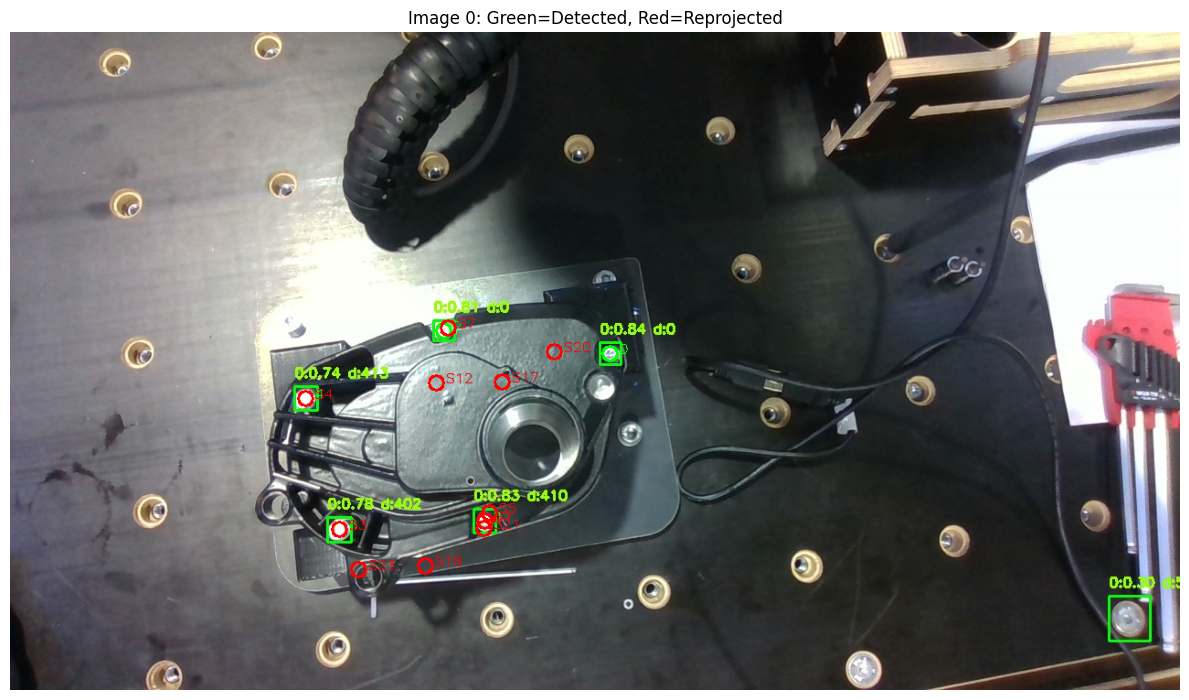

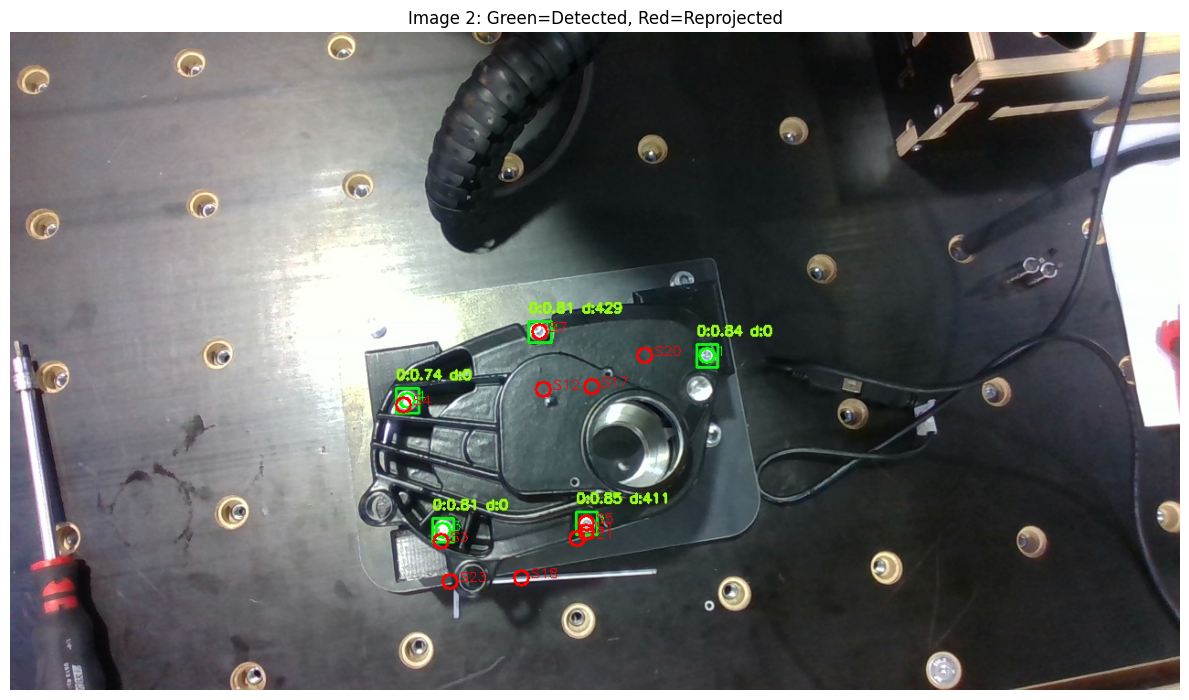

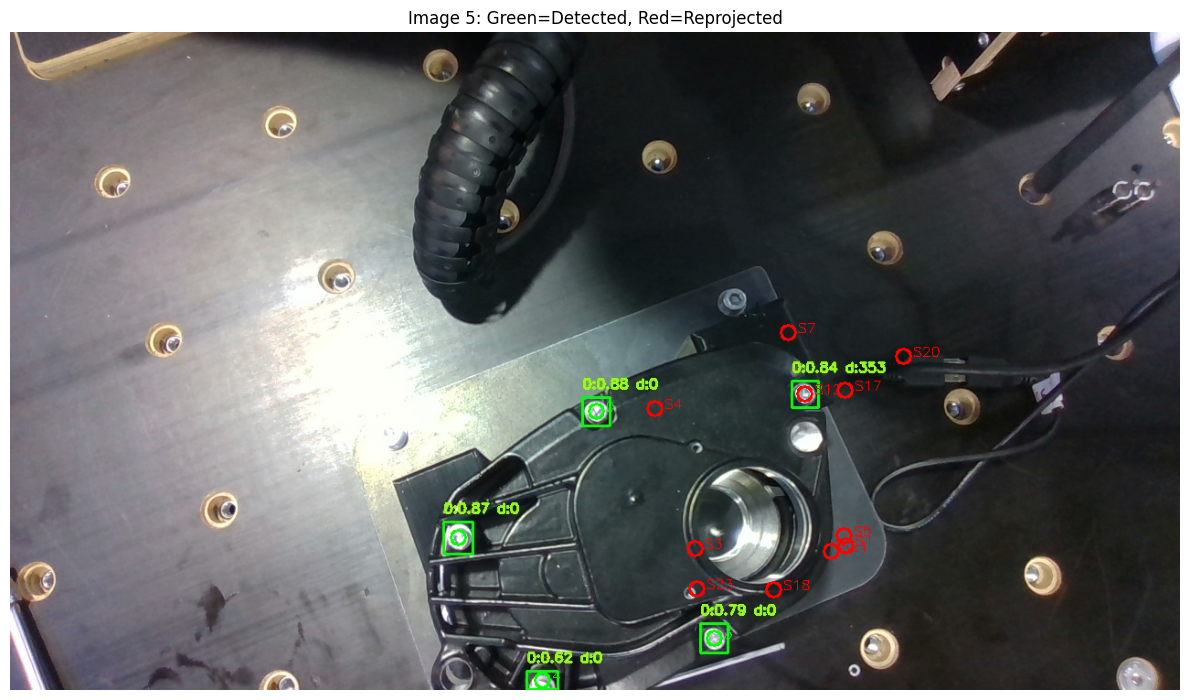

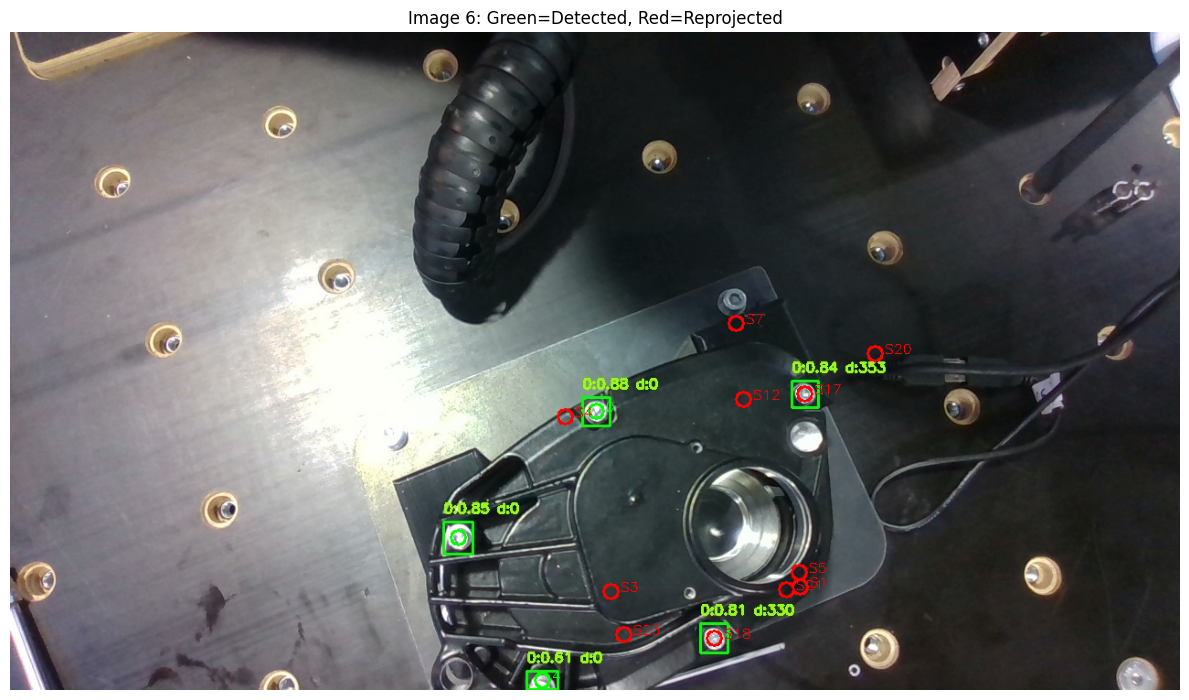

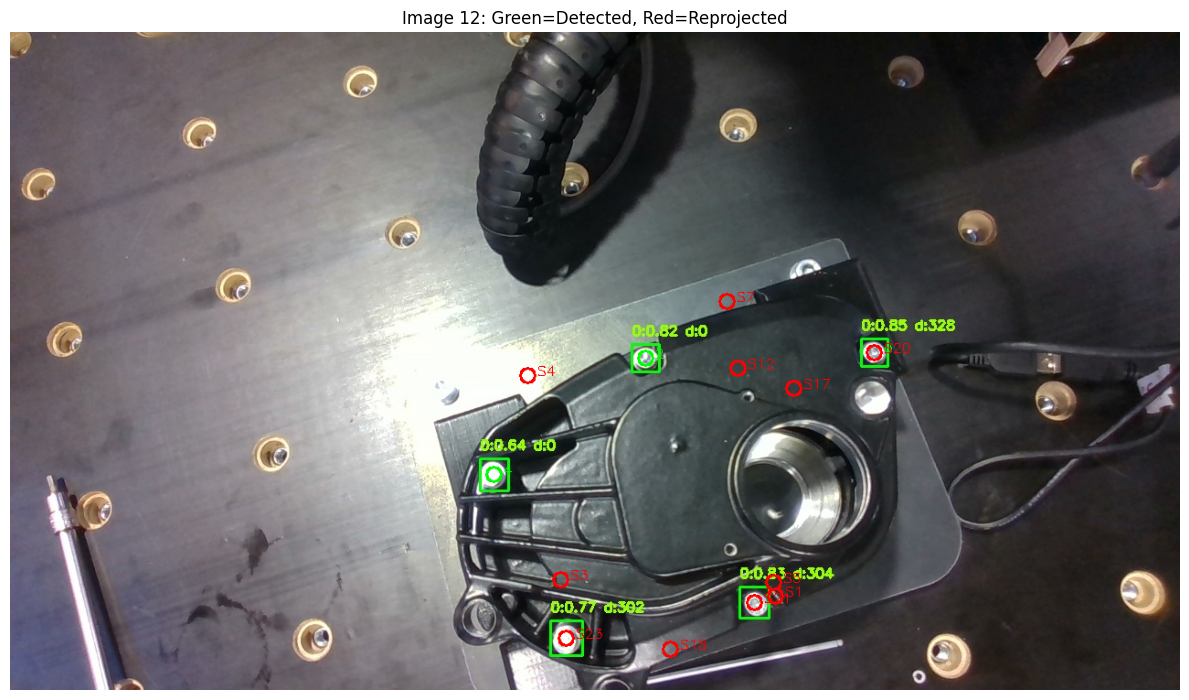

In [638]:
# Visualization of reprojections on images
import os
from pathlib import Path

# Find image directory
data_dir = Path("data/20260213_171657")
image_files = sorted(list(data_dir.glob("img_*.jpg")))

print(f"Found {len(image_files)} images")

# Create figure with subplots for each timestamp
fig_count = 0
for timestamp_id in sorted(data["img"].unique()):
    # Get detections for this image
    detections_this_img = data[data["img"] == timestamp_id]
    
    if len(detections_this_img) == 0:
        continue
    
    # Load corresponding image
    if timestamp_id < len(image_files):
        img_path = image_files[timestamp_id]
        img = cv2.imread(str(img_path))
        if img is None:
            print(f"Could not load image at {img_path}")
            continue
        
        img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img_display = img_rgb.copy()
        
        # Draw detected points (green circles)
        for _, det in detections_this_img.iterrows():
            det_x, det_y = int(float(det["x"])), int(float(det["y"]))
            cv2.circle(img_display, (det_x, det_y), 8, (0, 255, 0), 2)
            cv2.putText(img_display, str(int(det["ray_num"])), 
                       (det_x + 10, det_y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)
        
        # Draw reprojected points (red circles)
        pose_this_img = detections_this_img.iloc[0]["pose"]
        for screw_idx, final_point in enumerate(final_screw_positions):
            # Project 3D point to 2D
            point3D_hom = np.hstack((final_point, 1))
            point3D_cam_hom = np.dot(np.linalg.inv(pose_this_img), point3D_hom)
            point3D_cam = point3D_cam_hom[:3] / point3D_cam_hom[3]
            
            # Check if point is in front of camera
            if point3D_cam[2] > 0:
                point2D_hom = np.dot(K, point3D_cam)
                point2D = point2D_hom[:2] / point2D_hom[2]
                
                # Check if projected point is within image bounds
                px, py = int(point2D[0]), int(point2D[1])
                if 0 <= px < img_display.shape[1] and 0 <= py < img_display.shape[0]:
                    cv2.circle(img_display, (px, py), 8, (255, 0, 0), 2)  # Red
                    cv2.putText(img_display, f"S{screw_idx}", 
                                (px + 10, py), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)
        
        # Display
        plt.figure(figsize=(12, 8))
        plt.imshow(img_display)
        plt.title(f"Image {timestamp_id}: Green=Detected, Red=Reprojected")
        plt.axis("off")
        plt.tight_layout()
        plt.show()
        
        fig_count += 1